In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
import ipywidgets as widgets  # interactive display
from ipywidgets import fixed
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

#### Helper Functions

In [10]:
# @title Plotting functions
import matplotlib
def plot_circuit_responses(u, W, eigenstuff = False,
                           xlim='default',
                           ylim='default'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Set up axis limits
    if xlim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      xlim = [- extreme, extreme]
    if ylim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      ylim = [- extreme, extreme]

    # Set up look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set up tracking textz
    tracker_text = ax.text(.5, .9, "", color='w',
                           fontsize=20,
                           verticalalignment='top',
                           horizontalalignment='left',
                           transform=ax.transAxes)

    # Plot eigenvectors
    if eigenstuff:
      eigvals, eigvecs = np.linalg.eig(W)

      if np.abs(eigvals[0]) < np.abs(eigvals[1]):
        lc1 = 'c'
        lc2 = 'g'
      else:
        lc1 = 'g'
        lc2 = 'c'

      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 0],
              np.arange(-10000, 10000)*eigvecs[1, 0],
              lc1, alpha=.5, label = r'$\mathbf{v}_1$')
      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 1],
              np.arange(-10000, 10000)*eigvecs[1, 1],
              lc2, alpha=.5, label = r'$\mathbf{v}_2$')
      ax.legend()

    # Set up scatter
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=0, vmax=u.shape[1])
    ax.plot(u[0,:], u[1, :], alpha=.4, zorder = 0)
    scatter = ax.scatter(u[0, :], u[1, :], alpha=1,
                         c=cmap(norm(np.arange(u.shape[1]))),
                         zorder=1)


    ax.set(xlabel='Neuron 1 Firing Rate ($a_1$)',
           ylabel='Neuron 2 Firing Rate ($a_2$)',
           title='Neural firing over time')

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, label='Time step')
    
# @title Helper functions

def get_eigval_specified_matrix(target_eig):
  """Generates matrix with specified eigvals

    Args:
      target_eig (list): list of target eigenvalues, can be real or complex,
              should be length 2 unless you desire repeated eigenvalues
              with the same eigenvector, in which case length 1

    Returns:
      ndarray: 2 x 2 matrix with target eigvals

  """

  # Set up two eigenvectors
  V = np.array([[1, 1], [-1, 1]]).astype('float')
  for i in range(2):
    V[:, i] = V[:, i]/np.linalg.norm(V[:, i])

  # Get matrix with target eigenvalues
  if type(target_eig[0]) == int or type(target_eig[0]) == float:

    if len(target_eig) == 2: # distinct eigvecs (not necessarily distinct eigvals)

        D = np.diag(target_eig)
        A = V @ D @ np.linalg.inv(V)

    else: # repeated with same vec
      summed = 2*target_eig[0]

      a = summed - 3
      d = 3
      bc = target_eig[0]**2 - a*d
      factors = [n for n in range(1, bc+ 1) if bc % n == 0]
      b = factors[int(np.floor(len(factors)/2))]
      c = bc/-b

      A = np.array([[a, b], [c, d]])

  elif type(target_eig[0]) == complex:

      C = [np.real(V[:,0]), np.real(V[:,1])]
      B = np.array([[np.real(target_eig[0]), np.imag(target_eig[0])],
                    [-np.imag(target_eig[0]), np.real(target_eig[0])]]).squeeze()
      A = C @ B @ np.linalg.inv(C)

  return A

#### Ex1 Vector Normalize

In [4]:
def normalize_vector(input_vector):
  """ Normalizes a vector to length 1

  Inputs:
    input_vector (ndarray): array of shape (n_dim, ) where n_dim is the
        dimensionality of the vector

  Outputs:
    (ndarray): normalized vector of length 1
  """

  #################################################################################
  ## complete normalize_vector function ##
  #################################################################################

  # Compute vector length (use np.linalg.norm)
  vector_length = np.linalg.norm(input_vector)

  # Create normalized vector
  normalized_vector = input_vector / vector_length

  return normalized_vector

# Create vector v from above (use np.array)
v = np.array([3, 4])

# Call the function
v_unit = normalize_vector(v)

#### Ex2 Neural Transformations

In [5]:
P = np.array([[1,3], [2,1]])
g_p = np.array([16, 7])
r = np.linalg.solve(P, g_p)
print(r)

[1. 5.]


#### Ex3 Compute LGN

In [6]:
R = np.array([[0,1], [2, 4], [5, 1]])
W = np.array([[3, 2, 1], [1, 2, 7]])

G = W @ R
print(G)

[[ 9 12]
 [39 16]]


#### Circuit Implementation

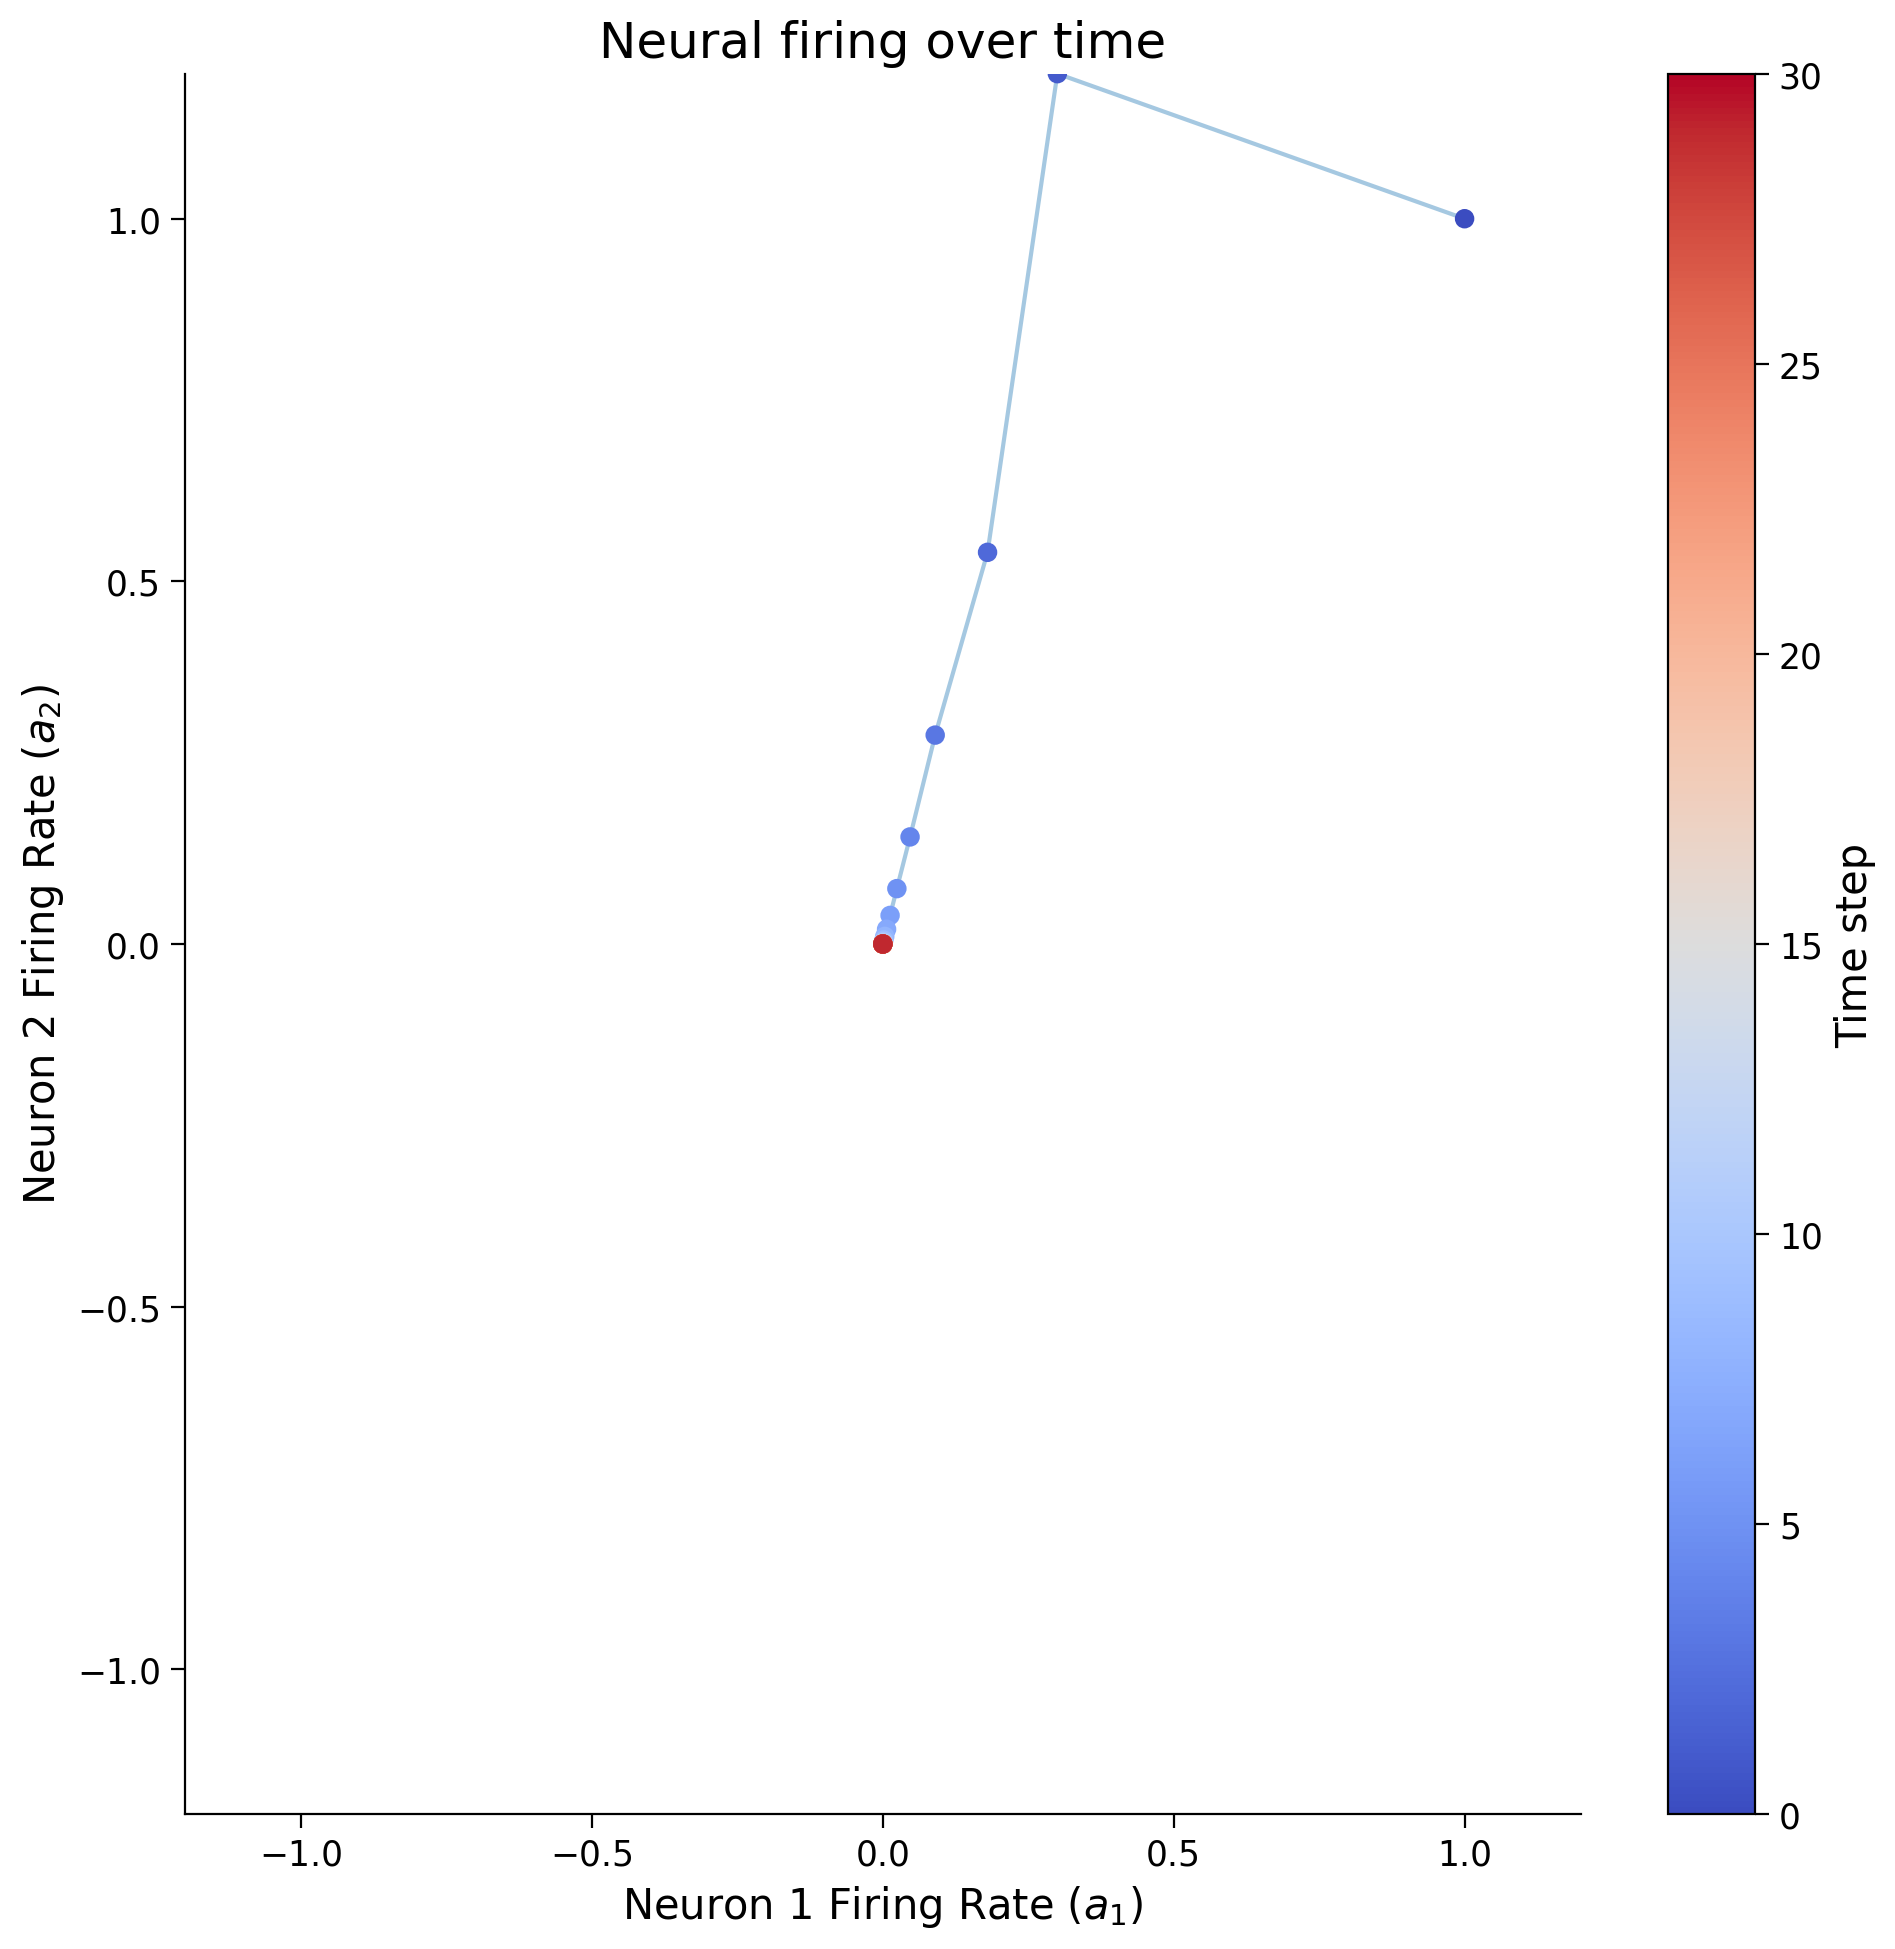

In [12]:
def circuit_implementation(W, a0, T):
  """ Simulate the responses of N neurons over time given their connections

  Args:
    W (ndarray): weight matrix of synaptic connections, should be N x N
    a0 (ndarray): initial condition or input vector, should be N,
    T (scalar): number of time steps to run simulation for

  Returns:
    a (ndarray): the neural responses over time, should be N x T

  """

  # Compute the number of neurons
  N = W.shape[0]

  # Initialize empty response array and initial condition
  a = np.zeros((N, T))
  a[:, 0]  = a0

  
  # Loop over time steps and compute u(t+1)
  for i_t in range(1, T):
      a[:, i_t] = W @ a[:, i_t - 1]

  return a


# Define W, u0, T
W = np.array([[.2, .1], [1, .2]])
a0 = np.array([1, 1])
T = 30

# Get neural activities
a = circuit_implementation(W, a0, T)

# Visualize neural activities
plot_circuit_responses(a, W)